#### Goal - show how the piping in coppertop makes it easier to do non-trivial computations in Excel doing a PCA on some equities as an example

I'm going to show my workings here - for didactic and requirements reasons


OPEN: groot needs explaining (add an issue)

In [1]:
%matplotlib inline

import datetime, polars as pl, matplotlib.pyplot as plt, pandas as pd

from coppertop.pipe import *
from bones.core.sentinels import Missing
import dm.core, dm.pp, dm.polarframe, dm.pandaframe, dm.fs, dm.linalg.core
from _ import *
from _ import dm, fs

<br>

#### piped function calls vs nested function calls

Many people seem to find the left to right style of pipeline style easier to read than nesting functions. Compare this:

In [2]:
list(filter(lambda x: x > 2, map(lambda x: x + 1, [1,2,3])))

[3, 4]

with this (where map => collect, filter => select):

In [3]:
[1,2,3] >> collect >> (lambda x: x + 1) >> select >> (lambda x: x > 2)

[3, 4]

or using the convention that a trailing underscore in a function names indicates a deferred function:

In [4]:
@coppertop(style=binary)
def collect_(xs, fn):
    return map(fn, xs)

@coppertop(style=binary)
def select_(xs, fn):
    return filter(fn, xs)

[1,2,3] >> collect_  >> (lambda x: x + 1) >> select_ >> (lambda x: x > 2) >> to >> list

[3, 4]

Just for interest these are the bones equivalents
```
(1,2,3) collect {x + 1} select {x > 2}
(1,2,3) collect_ {x + 1} select_ {x > 2} to <:N**count>

```


<br>

#### PCA

First - on a train journey I downloaded some stocks from Yahoo Finance - https://finance.yahoo.com/quote/MSFT/history?p=MSFT etc




In [5]:
fs >> DD

['XX', 'XX1', '__doc__', '__loader__', '__name__', '__package__', '__spec__', 'basename', 'deepDeleteEmptyFolders', 'deepDeleteFiles', 'deepDeleteFilesWithinSubfolders', 'deepFindFiles', 'deepFindFilesWithinSubfolders', 'deepFindNamedSubfolders', 'deepMoveFiles', 'deleteEmptyFolder', 'deleteFile', 'ensureFolder', 'ensureFolderWithXX', 'gid', 'hasFiles', 'isFile', 'isFolder', 'isFolderEmpty', 'joinPath', 'macosUnlock', 'mask2perm', 'modTime', 'moveFile', 'nanoToDT', 'perm2mask', 'ppDT', 'replicateFolders', 'scanFiles', 'scanFolders', 'size', 'stats', 'uid']


BModule(fs)

In [6]:
'./analysis/data' >> fs.scanFiles

['.DS_Store',
 'AMZN.csv',
 'MSFT.csv',
 'us yields.csv',
 'TSLA.csv',
 'GOOG.csv',
 'AAPL.csv']

In [7]:
'./analysis/data/AMZN.csv' >> dm.polars.csv.read

Date,Open,High,Low,Close,Adj Close,Volume
date,f64,f64,f64,f64,f64,i64
1997-05-15,0.121875,0.125,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.08125,0.085417,0.085417,122136000
1997-05-20,0.086458,0.0875,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.06875,0.071354,0.071354,377064000
1997-05-22,0.071875,0.072396,0.065625,0.069792,0.069792,235536000
1997-05-23,0.070313,0.076042,0.066667,0.075,0.075,318744000
1997-05-27,0.075521,0.082292,0.072917,0.079167,0.079167,173952000
1997-05-28,0.08125,0.081771,0.076563,0.076563,0.076563,91488000


or as a pandas dataframe

In [8]:
'./analysis/data/AMZN.csv' >> dm.polars.csv.read >> to >> pd.DataFrame

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6430,2022-12-01,96.989998,97.230003,94.919998,95.500000,95.500000,68488000
6431,2022-12-02,94.480003,95.360001,93.779999,94.129997,94.129997,72427000
6432,2022-12-05,93.050003,94.059998,90.820000,91.010002,91.010002,71535500
6433,2022-12-06,90.500000,91.040001,87.900002,88.250000,88.250000,75503600


In [9]:
d1 = datetime.date(2021, 12, 1)
d2 = datetime.date(2022, 11, 30)

AMZN = './analysis/data/AMZN.csv'  \
    >> dm.polars.csv.read \
    >> take >> ['Date', 'Close'] \
    >> select >> ((d1 <= pl.col("Date")) & (pl.col("Date") <= d2))
MSFT = './analysis/data/MSFT.csv'  \
    >> dm.polars.csv.read \
    >> take >> ['Date', 'Close'] \
    >> select >> ((d1 <= pl.col("Date")) & (pl.col("Date") <= d2))
AAPL = './analysis/data/AAPL.csv'  \
    >> dm.polars.csv.read \
    >> take >> ['Date', 'Close'] \
    >> select >> ((d1 <= pl.col("Date")) & (pl.col("Date") <= d2))
TSLA = './analysis/data/TSLA.csv'  \
    >> dm.polars.csv.read \
    >> take >> ['Date', 'Close'] \
    >> select >> ((d1 <= pl.col("Date")) & (pl.col("Date") <= d2))
GOOG = './analysis/data/GOOG.csv'  \
    >> dm.polars.csv.read \
    >> take >> ['Date', 'Close'] \
    >> select >> ((d1 <= pl.col("Date")) & (pl.col("Date") <= d2))

Let's join them together. I have aj (asof join for dataframes)

OPEN: aj needs to name the columns better - the standard polars ones are not scalable and the api should be the same accross all versions, maybe a kdb like column rename would be better.

OPEN: naming is slightly different for immutable languges - withNames for mutable languages, setNames for immutable - is `MSFT >> setNames >> [_,'MSFT']` good? q had xcols and xcol and I had to look up, `MSFT >> reorder >> ['MSFT']`


In [10]:
aj >> sig

['(bframe,bframe)->py <binary>  :   in .aj',
 '(polars.internals.dataframe.frame.DataFrame,polars.internals.dataframe.frame.DataFrame,txt,txt)->py <binary>  :   in .aj',
 '(polars.internals.dataframe.frame.DataFrame,polars.internals.dataframe.frame.DataFrame,txt,txt,txt)->py <binary>  :   in .aj']

OPEN: alias polars.internals.dataframe.frame.DataFrame as something clear and short \
let's try this (turns out to be a good guess but don't like the new name `Close_right`)

In [11]:
AMZN >> aj(_,_,'Date', 'Date') >> MSFT 

Date,Close,Close_right
date,f64,f64
2021-12-01,172.186005,330.079987
2021-12-02,171.867996,329.48999
2021-12-03,169.489502,323.01001
2021-12-06,171.3685,326.190002
2021-12-07,176.164505,334.920013
2021-12-08,176.158005,334.970001
2021-12-09,174.171005,333.100006
2021-12-10,172.212006,342.540009
2021-12-13,169.567505,339.399994


as I have to know that the new column name will be appended with "\_right" and that if I call it again it throws an error - to me the api just doesn't scale

In [12]:
try:
    AMZN \
        >> aj(_,_,'Date', 'Date') >> MSFT \
        >> aj(_,_,'Date', 'Date') >> AAPL 
except Exception as ex:
    ex >> PP

Cannot do hstack operation. Column with name: Close_right already exists


In [13]:
AMZN >> rename >> 'Close' >> 'AMZN'  \
    >> aj(_,_,'Date', 'Date') >> MSFT >> rename >> 'Close' >> 'MSFT' \
    >> aj(_,_,'Date', 'Date') >> AAPL >> rename >> 'Close' >> 'AAPL' 

Date,AMZN,MSFT,AAPL
date,f64,f64,f64
2021-12-01,172.186005,330.079987,164.770004
2021-12-02,171.867996,329.48999,163.759995
2021-12-03,169.489502,323.01001,161.839996
2021-12-06,171.3685,326.190002,165.320007
2021-12-07,176.164505,334.920013,171.179993
2021-12-08,176.158005,334.970001,175.080002
2021-12-09,174.171005,333.100006,174.559998
2021-12-10,172.212006,342.540009,179.449997
2021-12-13,169.567505,339.399994,175.740005


In [14]:
closesFrame = AMZN >> rename >> 'Close' >> 'AMZN' \
    >> aj(_,_,'Date', 'Date') >> MSFT >> rename >> 'Close' >> 'MSFT' \
    >> aj(_,_,'Date', 'Date') >> AAPL >> rename >> 'Close' >> 'AAPL' \
    >> aj(_,_,'Date', 'Date') >> TSLA >> rename >> 'Close' >> 'TSLA' \
    >> aj(_,_,'Date', 'Date') >> GOOG >> rename >> 'Close' >> 'GOOG'
closesFrame

Date,AMZN,MSFT,AAPL,TSLA,GOOG
date,f64,f64,f64,f64,f64
2021-12-01,172.186005,330.079987,164.770004,365.0,141.617996
2021-12-02,171.867996,329.48999,163.759995,361.533325,143.776505
2021-12-03,169.489502,323.01001,161.839996,338.323334,142.520493
2021-12-06,171.3685,326.190002,165.320007,336.33667,143.796494
2021-12-07,176.164505,334.920013,171.179993,350.583344,148.036499
2021-12-08,176.158005,334.970001,175.080002,356.320007,148.720505
2021-12-09,174.171005,333.100006,174.559998,334.600006,148.106003
2021-12-10,172.212006,342.540009,179.449997,339.01001,148.675003
2021-12-13,169.567505,339.399994,175.740005,322.136658,146.704498


We can do better

In [15]:
d1 = datetime.date(2021, 12, 1)
d2 = datetime.date(2022, 11, 30)

allSeries = ['AMZN', 'MSFT', 'AAPL', 'TSLA', 'GOOG'] >> collect >> (lambda name: 
    f'./analysis/data/{name}.csv'
        >> dm.polars.csv.read 
        >> take >> ['Date', 'Close']
        >> rename >> 'Close' >> name
        >> select >> ((d1 <= pl.col("Date")) & (pl.col("Date") <= d2))
) 

closesFrame = allSeries >> inject(_, Missing, _) >> (lambda prior, each: 
    each if prior is Missing else prior >> aj(_,_,'Date','Date') >> each
)

closesFrame

Date,AMZN,MSFT,AAPL,TSLA,GOOG
date,f64,f64,f64,f64,f64
2021-12-01,172.186005,330.079987,164.770004,365.0,141.617996
2021-12-02,171.867996,329.48999,163.759995,361.533325,143.776505
2021-12-03,169.489502,323.01001,161.839996,338.323334,142.520493
2021-12-06,171.3685,326.190002,165.320007,336.33667,143.796494
2021-12-07,176.164505,334.920013,171.179993,350.583344,148.036499
2021-12-08,176.158005,334.970001,175.080002,356.320007,148.720505
2021-12-09,174.171005,333.100006,174.559998,334.600006,148.106003
2021-12-10,172.212006,342.540009,179.449997,339.01001,148.675003
2021-12-13,169.567505,339.399994,175.740005,322.136658,146.704498


<br>

next take diffs and do the SVD (i.e. to generated the PCA loadings, aka eigenvectors, etc)

In [17]:
vs = closesFrame >> drop >> 'Date' >> takePanel >> diffRows>> dm.linalg.pca >> withKeys >> ['v','s']
v, s = vs >> values

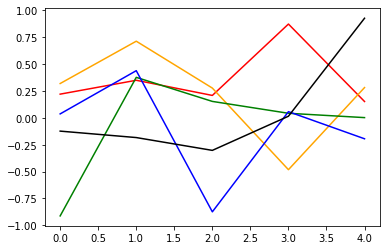

In [18]:
plt.plot(v >> atCol >> 0, 'red')
plt.plot(v >> atCol >> 1, 'orange')
plt.plot(v >> atCol >> 2, 'green')
plt.plot(v >> atCol >> 3, 'blue')
plt.plot(v >> atCol >> 4, 'black')

<br>

#### Putting it in Excel using pyxll

some code to call an anonymous python function via pyxll:

In [ ]:
import traceback, sys

@xl_func(auto_resize=True)
@xl_arg("srcOrFn", "union<str[], str>")
def pyFn(srcOrFn, *args):
    if isinstance(srcOrFn, list):
        srcOrFn = '\n'.join(srcOrFn)
    fn = eval(srcOrFn, globals())
    try:
        answer = fn(*args)
    except Exception as ex:
        et, ev, tb = sys.exc_info()
        lines = ['PYTHON TRACEBACK']
        for e in traceback.format_exception(et, ev, tb):
            lines.extend(e.split('\n'))
        return lines
    return answer


doing the svd in exel:

```
=pyFn("lambda x: x >> drop >> 'Date' >> takePanel >> diffRows>> dm.linalg.pca >> withKeys >> ['v','s']", {cell with closesFrame object})
```